# Part 3: Regression for joint angles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

# Part 3.1: Visualizing and preprocessing the data

## 3.1.1 Downloading the dataset and checking the data structure.

In [2]:
# load EMG data
data = loadmat("data/part_3/S1_E1_A1.mat")

### Dataset variables

In [3]:
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


### Dataset shape

In [4]:
#Performing a copy of the data
emg_data = data["emg"].copy()
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 
#glove is the calibrated signal from the sensors of the cyberglove
glove = data ["glove"]

print(f'Shape of Data \n    EMG: {emg_data.shape}\n    Stimulus {stimulus.shape}\n   Repetition {repetition.shape}\n Glove {glove.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_data.shape[1]

print('***')
print(f'Number of \n    Movements: {n_stimuli}\n    Repetitions: {n_repetitions}')

Shape of Data 
    EMG: (2292526, 16)
    Stimulus (2292526, 1)
   Repetition (2292526, 1)
 Glove (2292526, 18)
***
Number of 
    Movements: 9
    Repetitions: 10


### Extracting only relevant joints (3,6,8,11,14)

 Joint angles are involved in all movements so we consider all the EMG data

In [5]:
joint_angles = glove[:,[3,6,8,11,14]]

print("Joint angles data dimension: {}".format(joint_angles.shape))
print("Joint angles data type: {}".format(type(joint_angles)))

Joint angles data dimension: (2292526, 5)
Joint angles data type: <class 'numpy.ndarray'>


## 3.1.2 EMG Pre-processing

In [6]:
fs = 2000 #fs found in data description
data_shape = emg_data.shape
number_timepoints = emg_data.shape[0]
number_channels = emg_data.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {number_timepoints} timepoints')
print(f'There are {number_channels} channels')

The shape of the data is (2292526, 16)
There are 2292526 timepoints
There are 16 channels


### Visualizing the EMG signals (I'm assuming here that it's in Volt not microvolt)

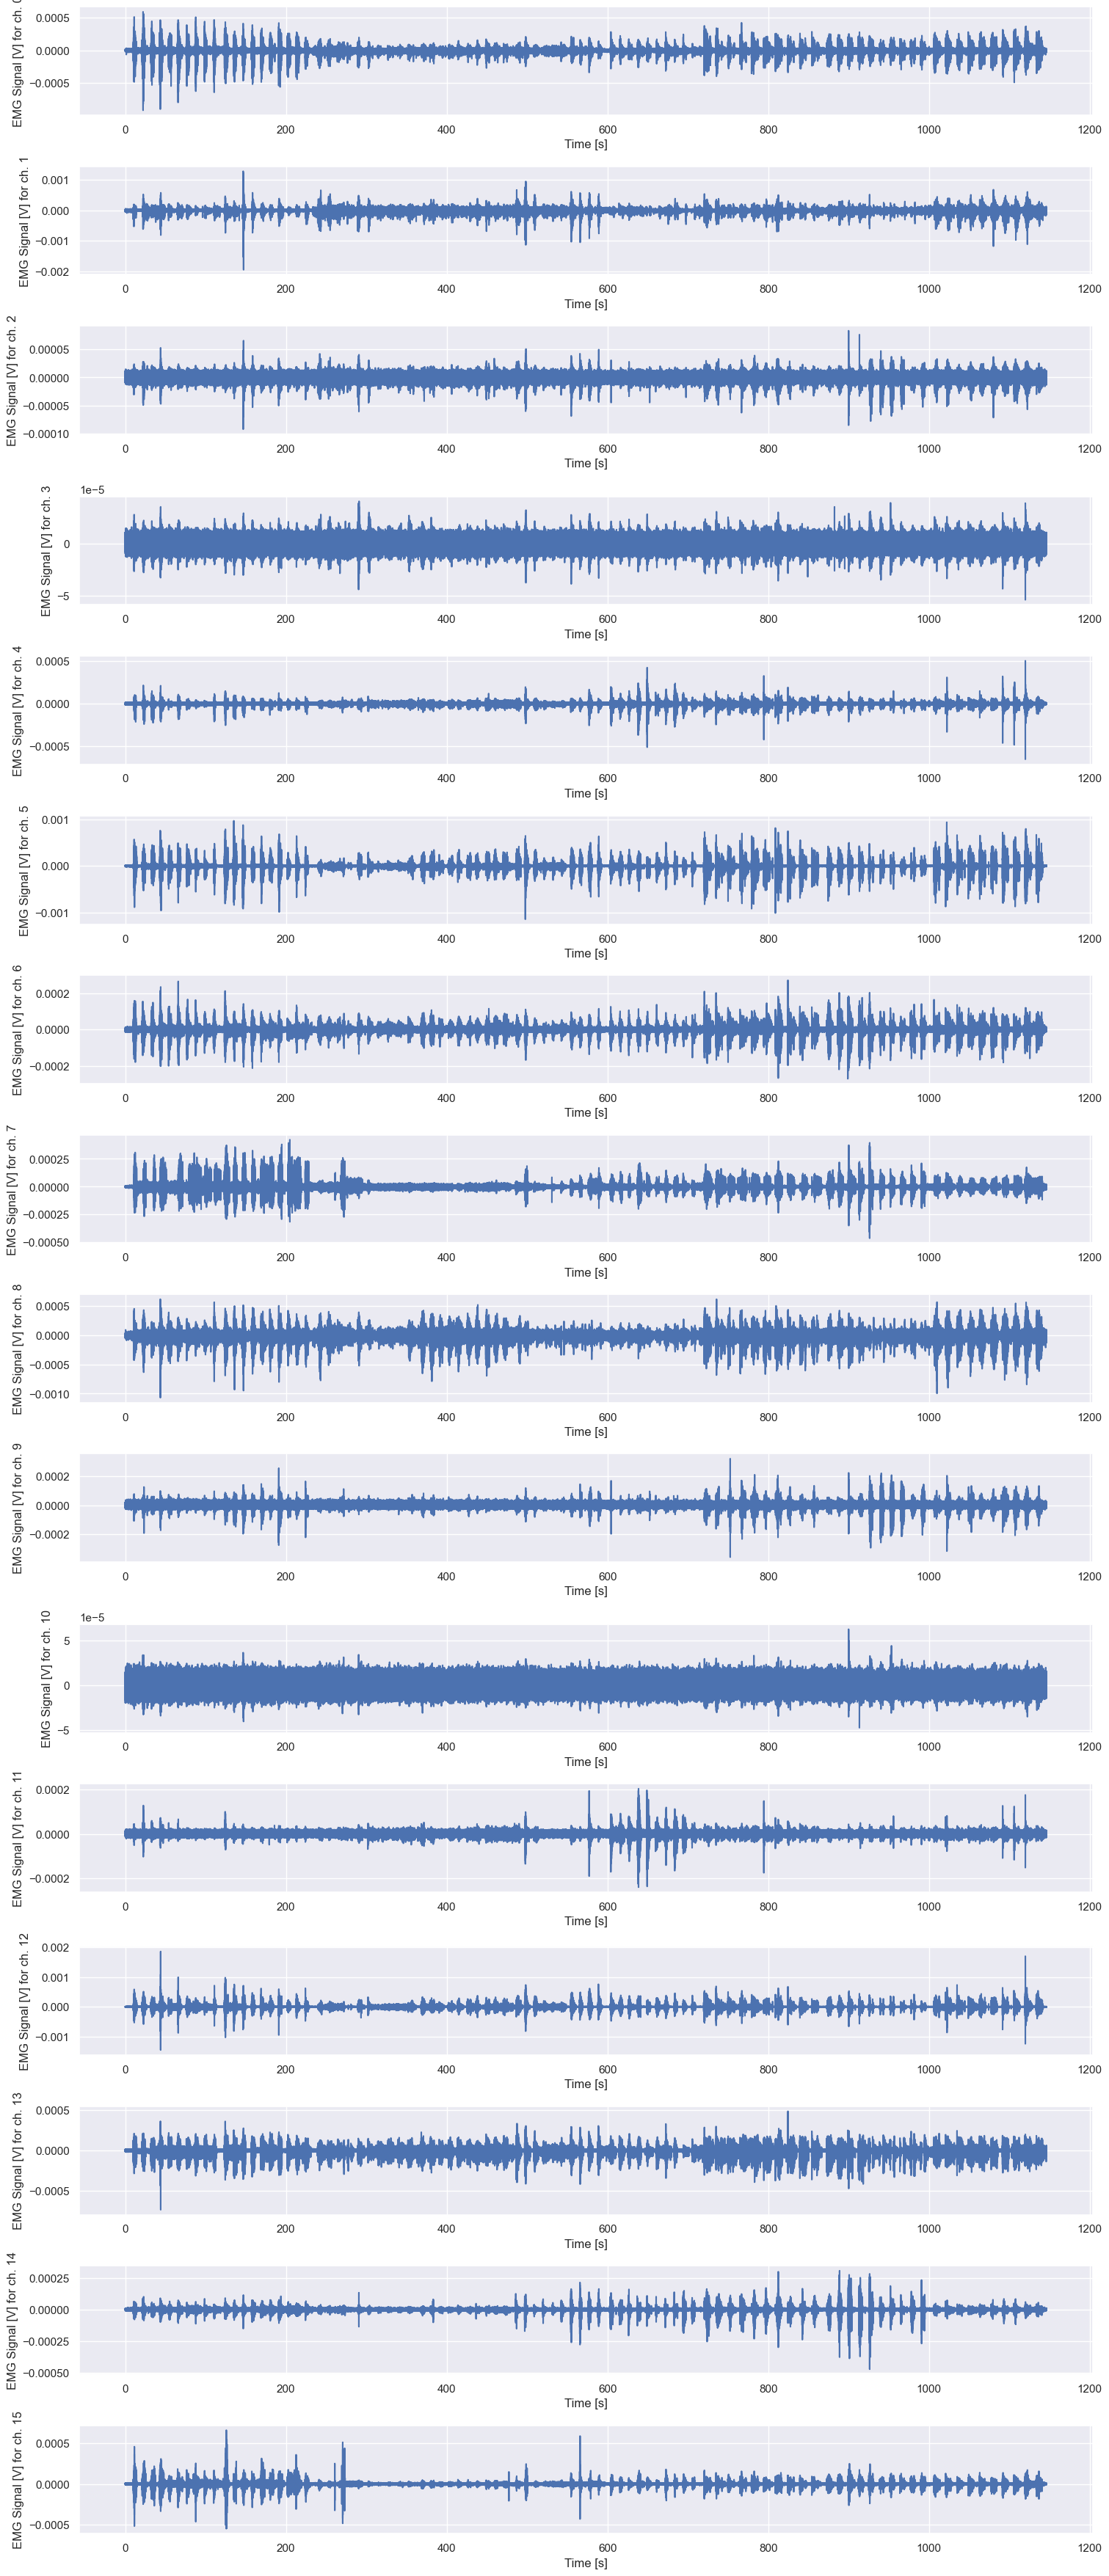

In [7]:
n_channels = emg_data.shape[1]

time_steps = np.arange(0,emg_data.shape[0]/fs, 1/fs) #Time vector for plotting

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 35),  gridspec_kw={'hspace': 0.1})
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_data[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f'EMG Signal [V] for ch. {channel_idx}')


We will use the welsh method to confirm if further filtering is indeed needed

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

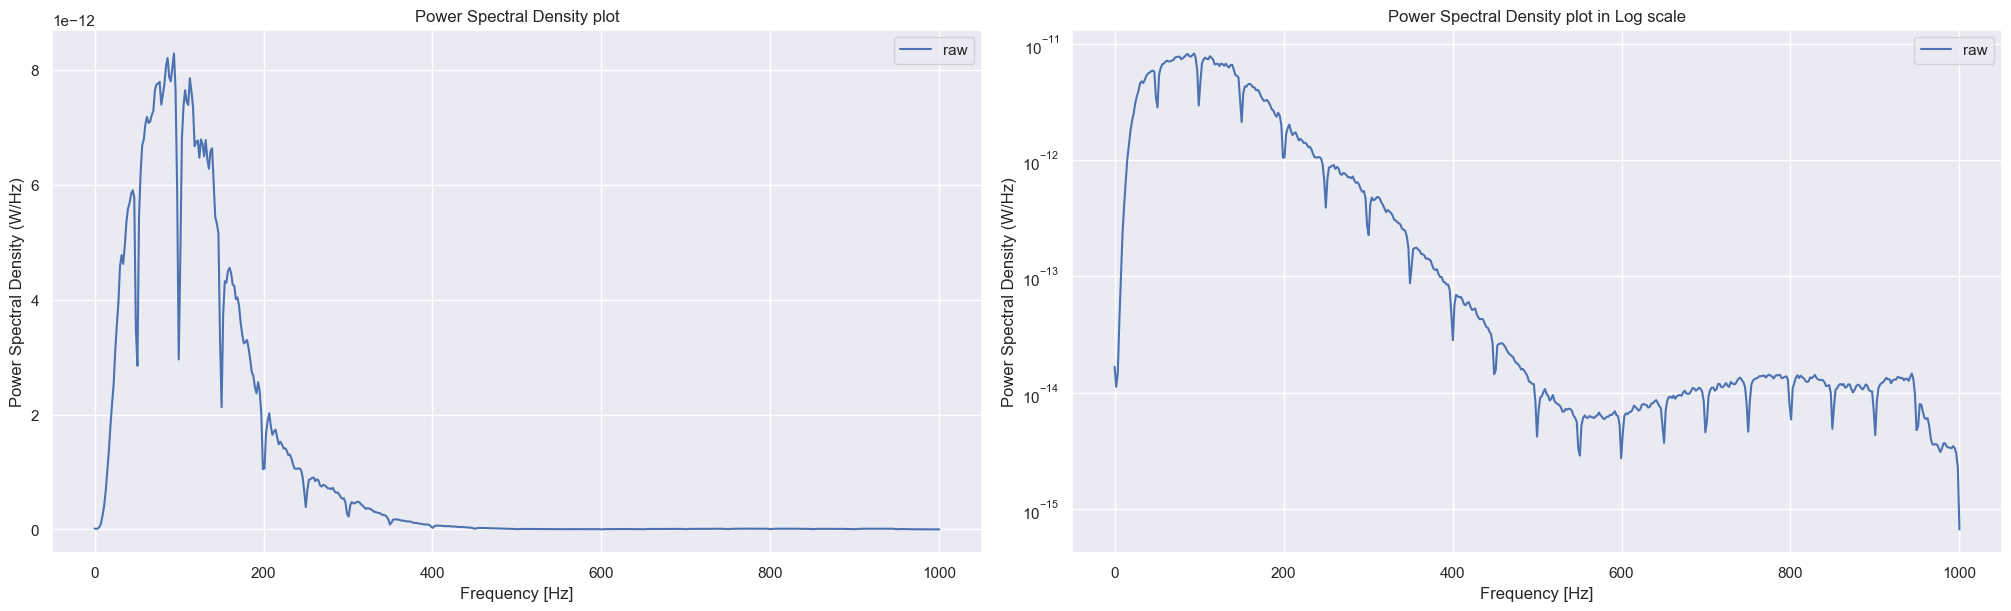

In [8]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 0], fs=fs, nperseg=1064) 


fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 6))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

Filtering might not be needed since the high frequency noise presenting in the PSD log sclae plot seems to have a very low amplitude but we will still proceed with filtering to be safe.

### Denoise Filtering

We apply a bandpass filter with the lower threshold equal to 5 Hz to remove artifacts and the higher threshold equal to 500 Hz sine EMG signals are usually below that frequency, while ensuring the removal of high frequency noise.
Powerline noise and it's harmonics (50 Hz and its integer multiples) seem already filtered, but we will redo this step in order to be safe.

In [9]:
# defining filtering function:
def apply_emg_filtering(emg_data, fs):

    # Fixed bandpass cutoff frequencies
    bandpass_cutoff_frequencies_Hz = (5, 500)  # Passband: 5-500 Hz
    sos = butter(N=4, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_data.T).T

    # Fixed power grid harmonics count (50 Hz and 100 Hz)
    powergrid_harmonics_count = 2
    powergrid_noise_frequencies_Hz = [harmonic_idx * 50 for harmonic_idx in range(1, powergrid_harmonics_count + 1)]

    # Apply notch filters for power grid noise
    for noise_frequency in powergrid_noise_frequencies_Hz:
        sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
        emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

    return emg_filtered

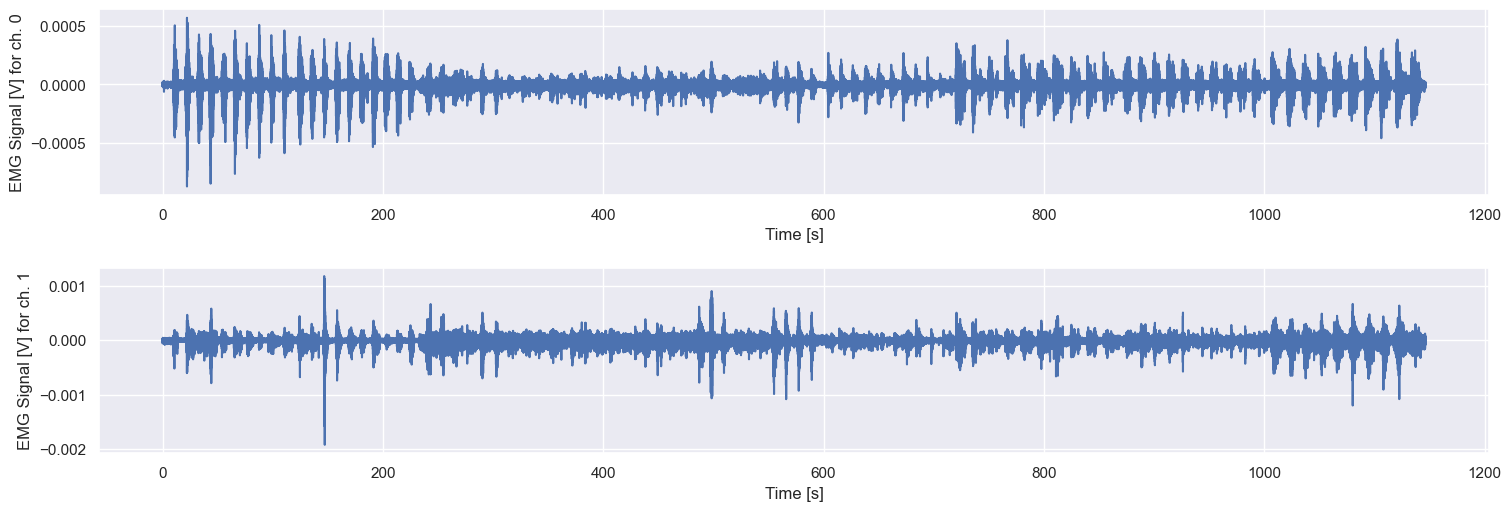

In [10]:
# apply bandpass filter

emg_filtered = apply_emg_filtering(emg_data= emg_data, fs= fs)

fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(15, 5),  gridspec_kw={'hspace': 0.1})
for channel_idx in range(2):
    ax[channel_idx].plot(time_steps, emg_filtered[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f'EMG Signal [V] for ch. {channel_idx}')


### Verification:

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

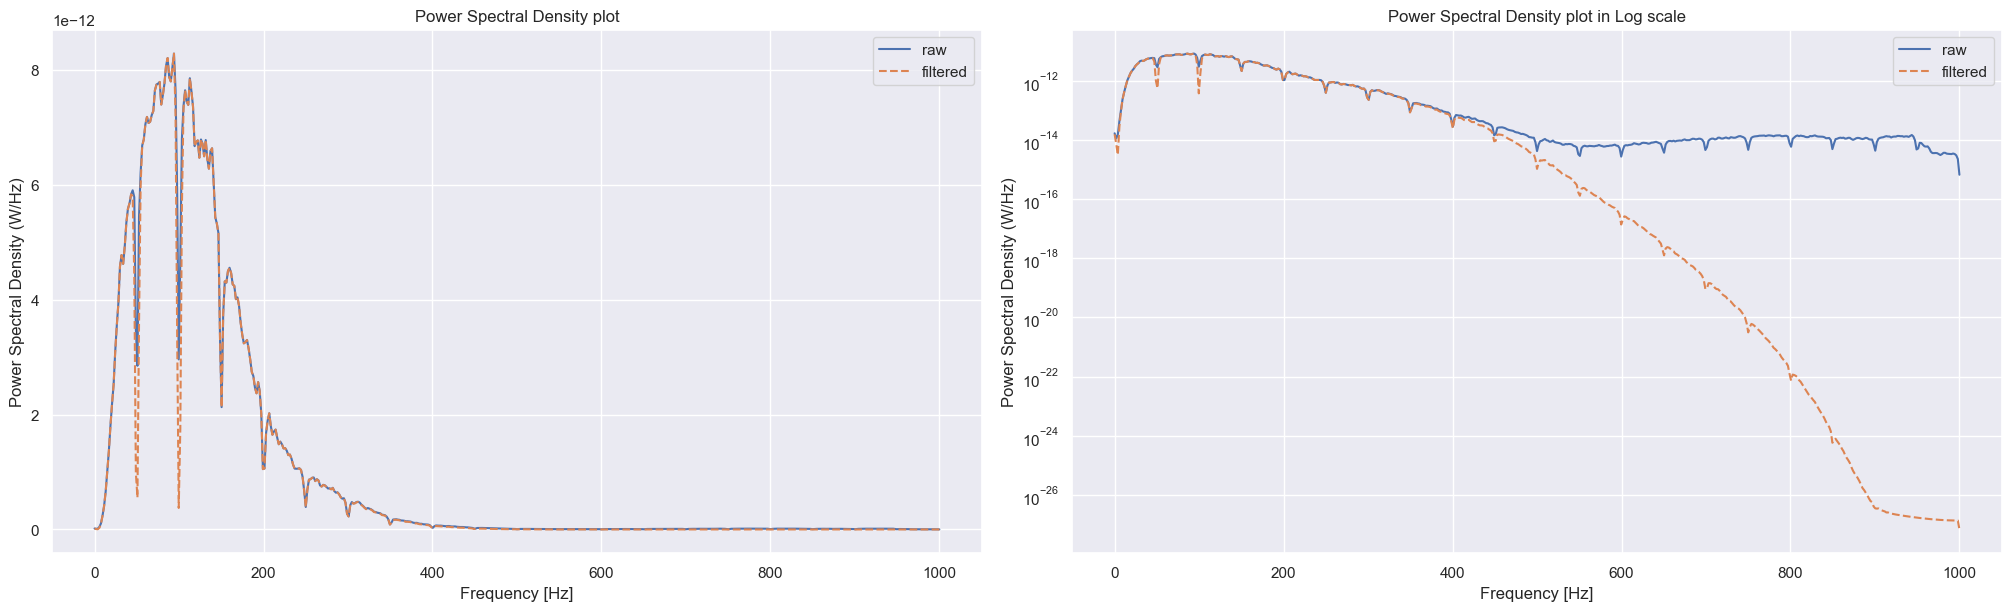

In [11]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 0], fs=fs, nperseg=1064)
freqs_post, Pxx_post = welch(emg_filtered[:, 0],fs = fs,  nperseg=1064)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 6))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].plot(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].semilogy(freqs_post, Pxx_post, linestyle="--", label="filtered")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

### Rectifying the EMG signal

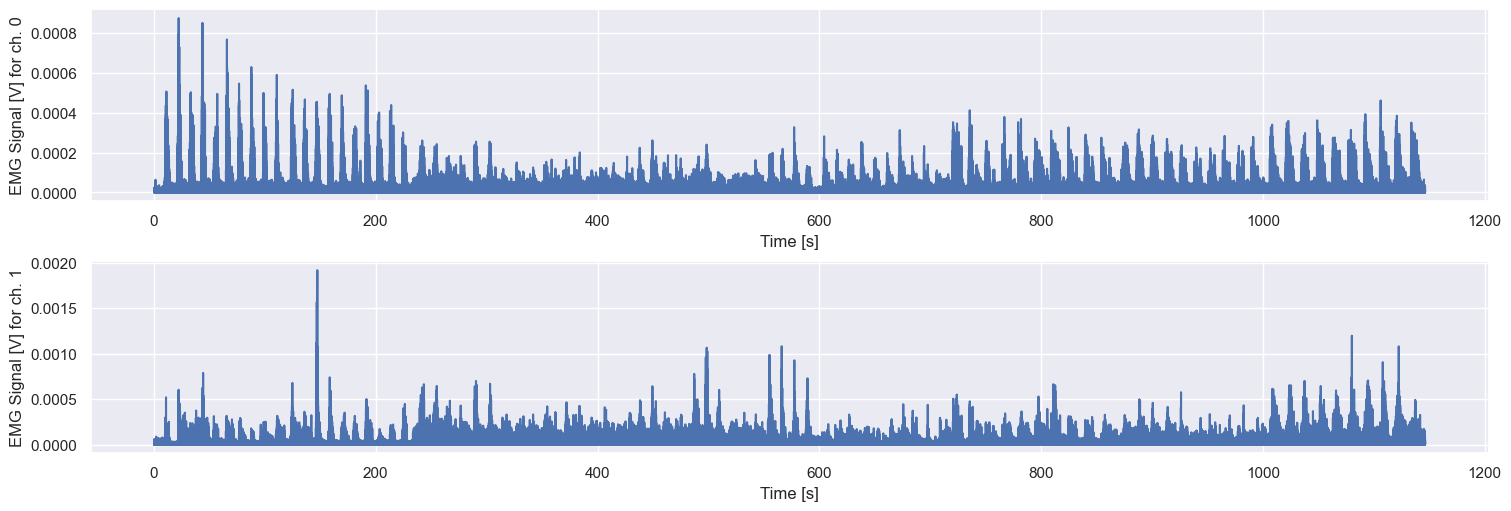

In [12]:
# Rectify signals
emg_rectified = np.abs(emg_filtered) # Rectify the signal

fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(15, 5))
for channel_idx in range(2):
    ax[channel_idx].plot(time_steps, emg_rectified[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel(f'EMG Signal [V] for ch. {channel_idx}')

## 3.1.3 Visualizing the stimulus and repition values and checking for faulty recordings and trials

Once again we look at the shape of our data

In [13]:
#Performing a copy of the data
emg_data = data["emg"].copy()
#Stimulus is the type of movement that is being performed
stimulus = data["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data["rerepetition"] 
#glove is the calibrated signal from the sensors of the cyberglove
glove = data ["glove"]

print(f'Shape of Data \n    EMG: {emg_data.shape}\n    Stimulus {stimulus.shape}\n   Repetition {repetition.shape}\n Glove {glove.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 
n_channels = emg_data.shape[1]

print('***')
print(f'Number of \n    Movements: {n_stimuli}\n    Repetitions: {n_repetitions}')

Shape of Data 
    EMG: (2292526, 16)
    Stimulus (2292526, 1)
   Repetition (2292526, 1)
 Glove (2292526, 18)
***
Number of 
    Movements: 9
    Repetitions: 10


we also look at how many samples each trial contains

In [14]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[ 8546.,  8461., 10597.,  8151.,  8644.,  8252.,  8521.,  8298.,
         7427.,  5667.],
       [ 9115.,  9415.,  8037.,  8448.,  8860., 10944.,  8988., 13083.,
         8368.,  8584.],
       [11467., 18607., 14109., 19190., 10784., 15483., 18764., 18536.,
        18548., 14980.],
       [10518., 10661., 16355., 13664., 10125., 12664., 10907., 11208.,
        11569., 13179.],
       [13289.,  7796.,  8816., 16365., 17022., 16156.,  9687.,  7471.,
         8259.,  7876.],
       [ 9196.,  8780.,  6955.,  8730.,  8077., 13721.,  7249.,  8435.,
         8349.,  9100.],
       [17544., 20935., 17096., 16700., 17954., 16925., 17603., 16830.,
        16744., 16994.],
       [11440., 12298., 12315., 11262., 12056., 10792., 11056., 13483.,
        12632., 13002.],
       [15143., 14371., 13857., 14971., 15306., 15432., 15275., 14779.,
        14763., 15740.]])

### Computing the envelope of the signal (to check for bad trials)

Since the number of samples for each trial is different, we will be using a nested list called emg_envelopes to contain and access the data in the subsequent analysis

In [15]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

In [16]:
print(emg_envelopes[0][0])
print(len(emg_envelopes[0][0]))

[[9.99241243e-06 1.64450911e-05 4.80452376e-06 ... 1.64232740e-05
  2.73017114e-06 5.52031784e-06]
 [1.09005854e-05 1.64836186e-05 4.74912429e-06 ... 1.64044486e-05
  2.61856048e-06 5.30878645e-06]
 [1.27184940e-05 1.65395261e-05 4.70788303e-06 ... 1.63329879e-05
  2.60803757e-06 5.28051337e-06]
 ...
 [6.64402001e-06 4.33465490e-06 5.22469562e-06 ... 9.82963497e-06
  2.81163776e-06 4.96155677e-06]
 [6.60518106e-06 4.40868873e-06 5.26206063e-06 ... 9.16162782e-06
  2.79574113e-06 5.13428690e-06]
 [6.52508991e-06 4.56083960e-06 5.21914347e-06 ... 8.23824155e-06
  2.88648118e-06 5.28508034e-06]]
8546


Structure of emg_envelopes:

1st dimension: 9 movements

2nd dimension: 10 repetitions

3rd dimension: inhomogeneous with size equal to amount of samples or timestamps per trial

for example: emg_envelopes[0][0] contains 8546 16X1 arrays, the 8546 corresponds to the timesatmps in this specific trial, each timestamp is represented by a 16X1 array that gives the values of the 16 channels at that timestamp.

4rth dimension: 16X1 array

### Plottig a specific repition (1st repition of 1st stimuli)

This should allow us to notice any bad channels

Text(0.5, 0.98, 'Envelopes of the EMG signal of repition 0 of stimulus 0')

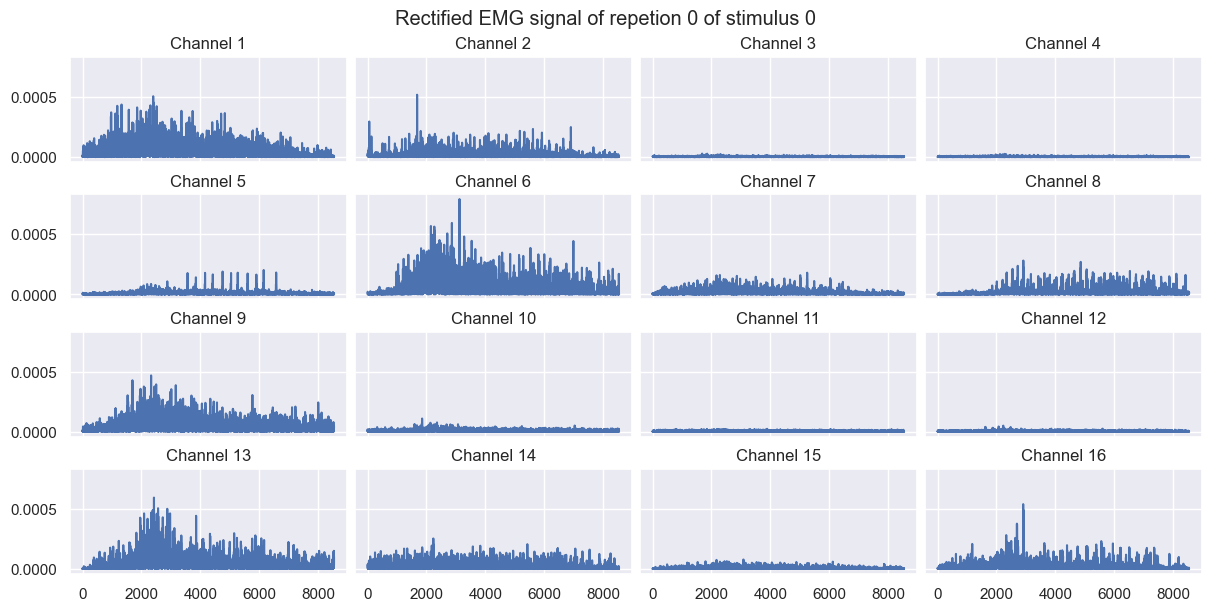

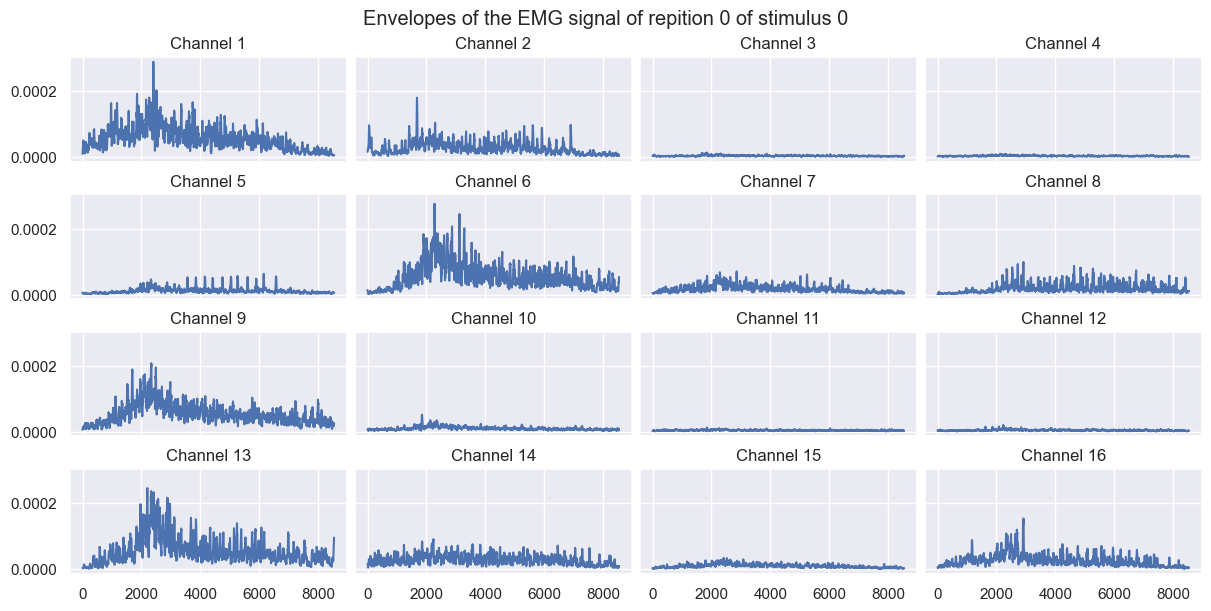

In [17]:
fig, ax = plt.subplots(4, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

# Selecting the stimulus and repetition to plot the 10 EMG channels
number_of_emg_channels = emg_rectified.shape[-1] 
stimulus_id = 0
repetition_id = 0

# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[stimulus_id][repetition_id][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle(f'Rectified EMG signal of repetion {repetition_id} of stimulus {stimulus_id}')

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(4, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[stimulus_id][repetition_id][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle(f'Envelopes of the EMG signal of repition {repetition_id } of stimulus {stimulus_id}')

All the channels look relatively normal and there seems to be no need for channel removal.

### Visualizing accross repitions

In [18]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

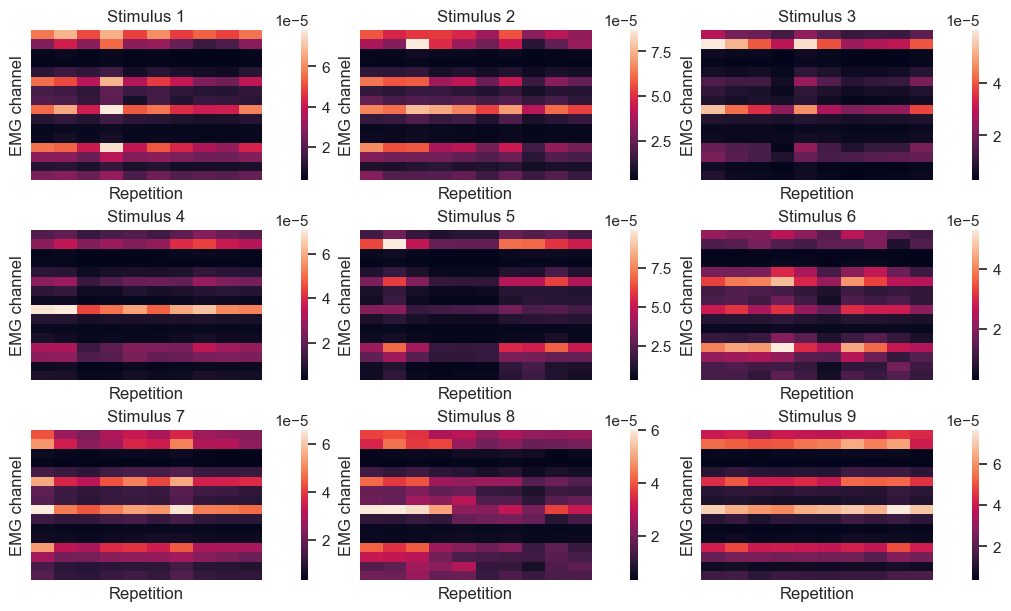

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

## INTERPRET!!!! (say looks relatively good so we will not take out any trials

## Part 3.1.4: Pre-processing the test dataset

The dataset S1_E1_A2 is used for testing, and since the data acquisition protocol is the same as our train data we performed our previous analysis on, we will asume that it's safe to perform the same pre-processing steps on this dataset.

In [20]:
# load EMG data
data_test = loadmat("data/part_3/S1_E1_A2.mat")

In [21]:
#Performing a copy of the data
emg_data_test = data_test["emg"].copy()
#Stimulus is the type of movement that is being performed
stimulus_test = data_test["restimulus"] 
#Repetition is the number of times the movement has been repeated
repetition_test = data_test["rerepetition"] 
#glove is the calibrated signal from the sensors of the cyberglove
glove_test = data_test["glove"]

print(f'Shape of Data \n    EMG: {emg_data_test.shape}\n    Stimulus {stimulus_test.shape}\n   Repetition {repetition_test.shape}\n Glove {glove_test.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus_test)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition_test)) - 1 
n_channels = emg_data_test.shape[1]

print('***')
print(f'Number of \n    Movements: {n_stimuli}\n    Repetitions: {n_repetitions}')

Shape of Data 
    EMG: (2313470, 16)
    Stimulus (2313470, 1)
   Repetition (2313470, 1)
 Glove (2313470, 18)
***
Number of 
    Movements: 9
    Repetitions: 10


In [22]:
joint_angles_test = glove_test[:,[3,6,8,11,14]]

print("Joint angles data dimension: {}".format(joint_angles_test.shape))
print("Joint angles data type: {}".format(type(joint_angles_test)))

Joint angles data dimension: (2313470, 5)
Joint angles data type: <class 'numpy.ndarray'>


In [23]:
# filtering
emg_filtered_test = apply_emg_filtering(emg_data= emg_data_test, fs= fs)

In [24]:
# Rectify signals
emg_rectified_test = np.abs(emg_filtered_test) # Rectify the signal

## Part 3.2 Performing sliding window

### Envelopping and visualizing joint angles 3,6,8,11,14 with enveloped EMG

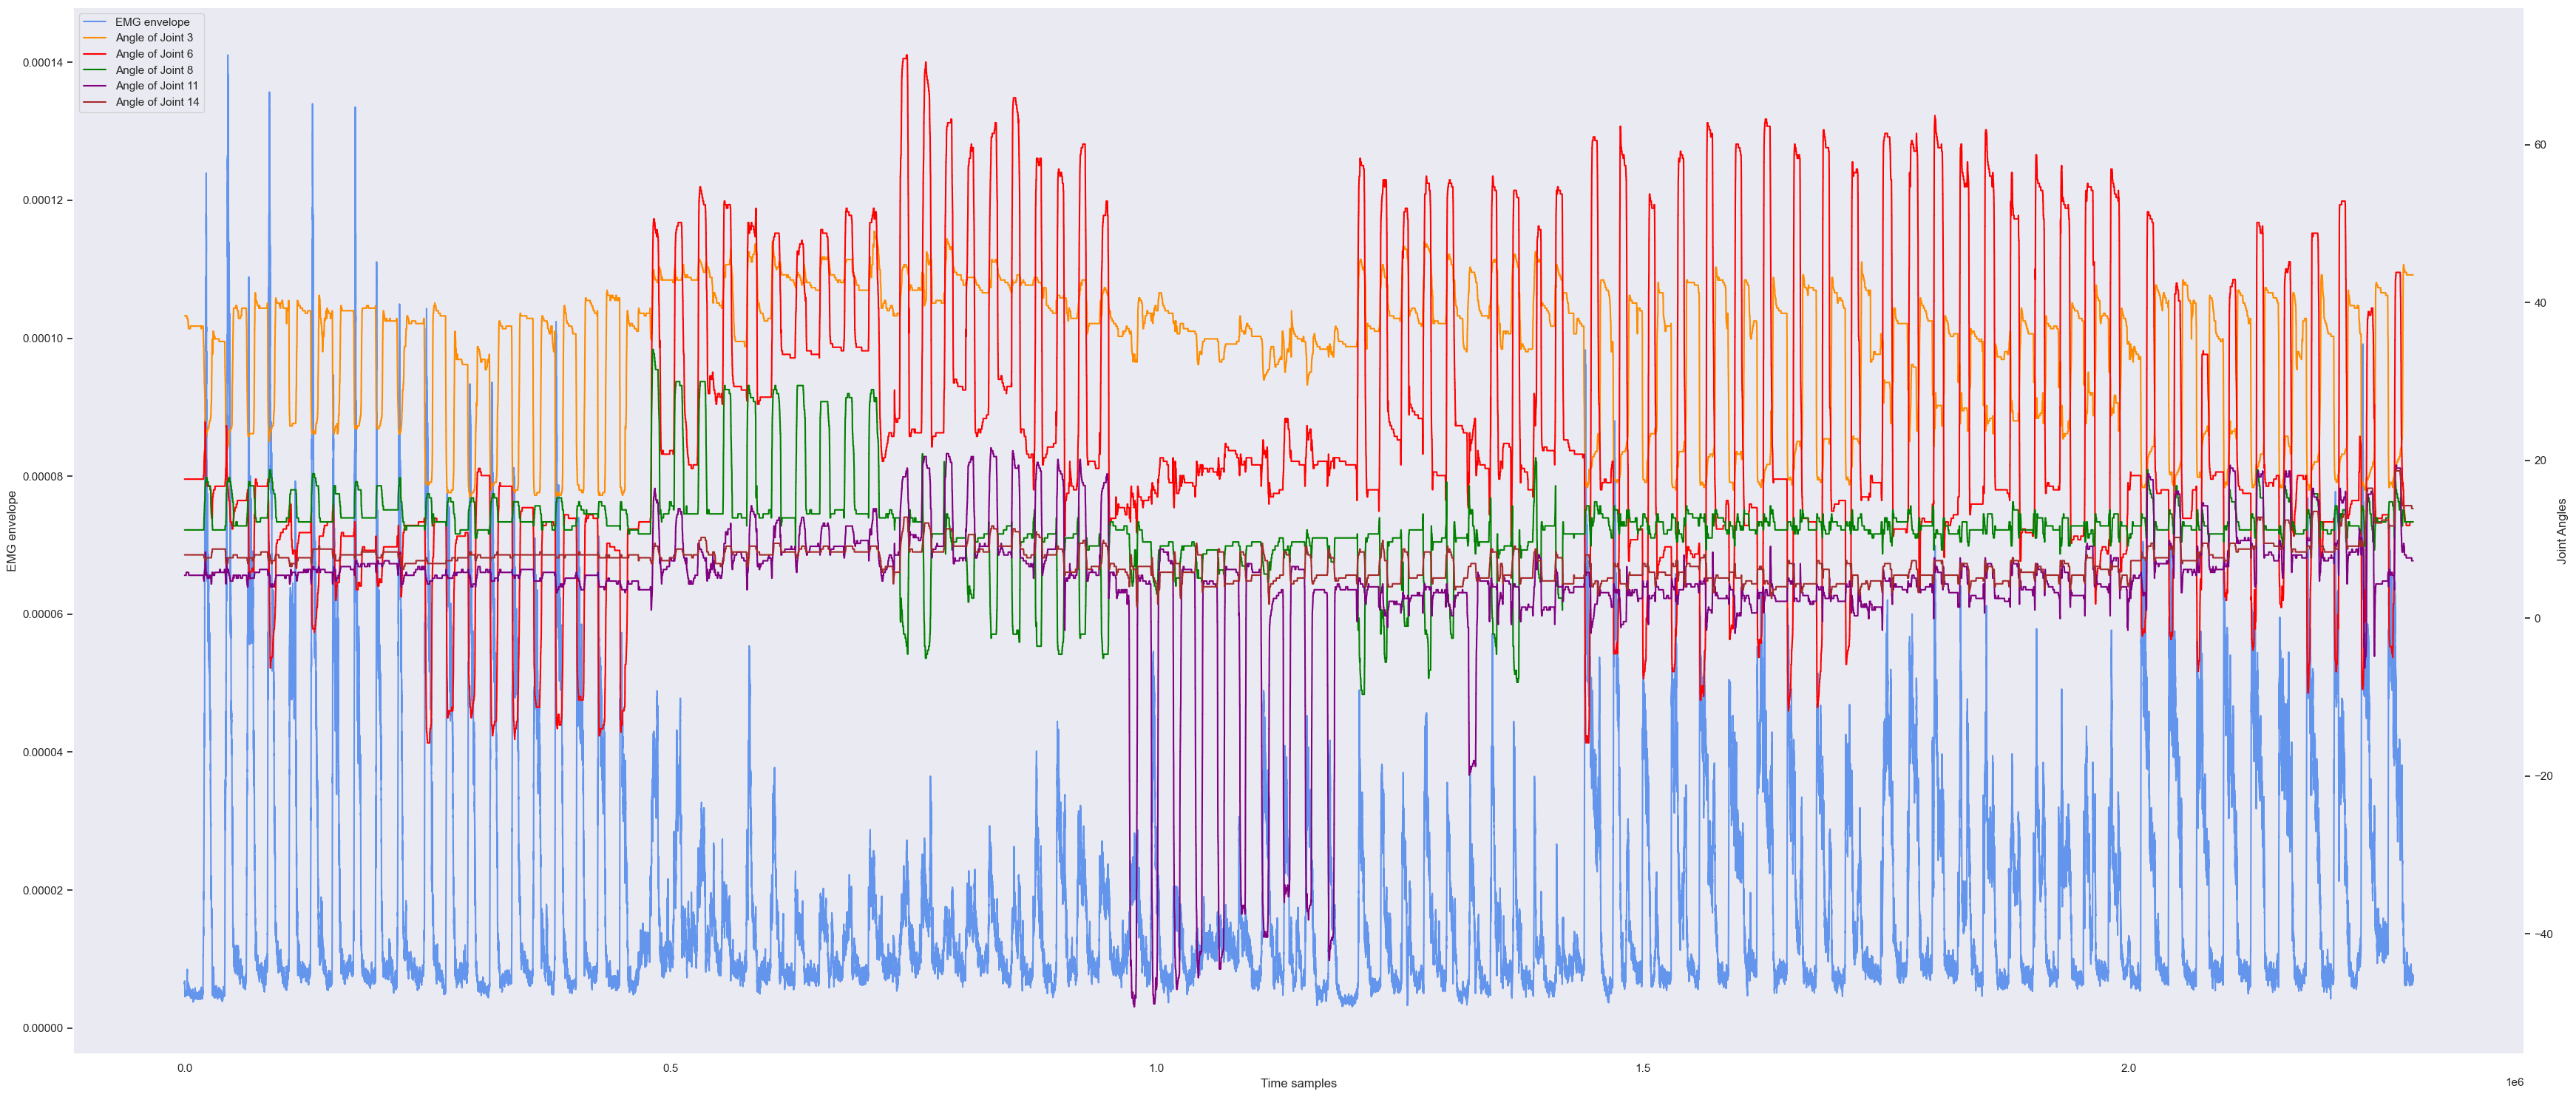

In [25]:
# For Train dataset
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_rectified, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots(figsize=(35, 15))

# Plot the EMG envelope
ax.plot(EMG_envelopes[:, 0], color='cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

# Create a twin axis for joint angles
joint_angle_ax = ax.twinx()

# Plot the joint angles
joint_angle_ax.plot(joint_angles[:, 0], color="darkorange", label="Angle of Joint 3")
joint_angle_ax.plot(joint_angles[:, 1], color="red", label="Angle of Joint 6")
joint_angle_ax.plot(joint_angles[:, 2], color="green", label="Angle of Joint 8")
joint_angle_ax.plot(joint_angles[:, 3], color="purple", label="Angle of Joint 11")
joint_angle_ax.plot(joint_angles[:, 4], color="brown", label="Angle of Joint 14")

# Set label for joint angles axis
joint_angle_ax.set_ylabel("Joint Angles")
joint_angle_ax.grid(False)

# Get handles and labels from both axes
emg_handles, emg_labels = ax.get_legend_handles_labels()
joint_handles, joint_labels = joint_angle_ax.get_legend_handles_labels()

# Combine handles and labels for a single legend
combined_handles = emg_handles + joint_handles
combined_labels = emg_labels + joint_labels

# Add a combined legend
ax.legend(combined_handles, combined_labels, loc='upper left')

plt.tight_layout()
plt.show()

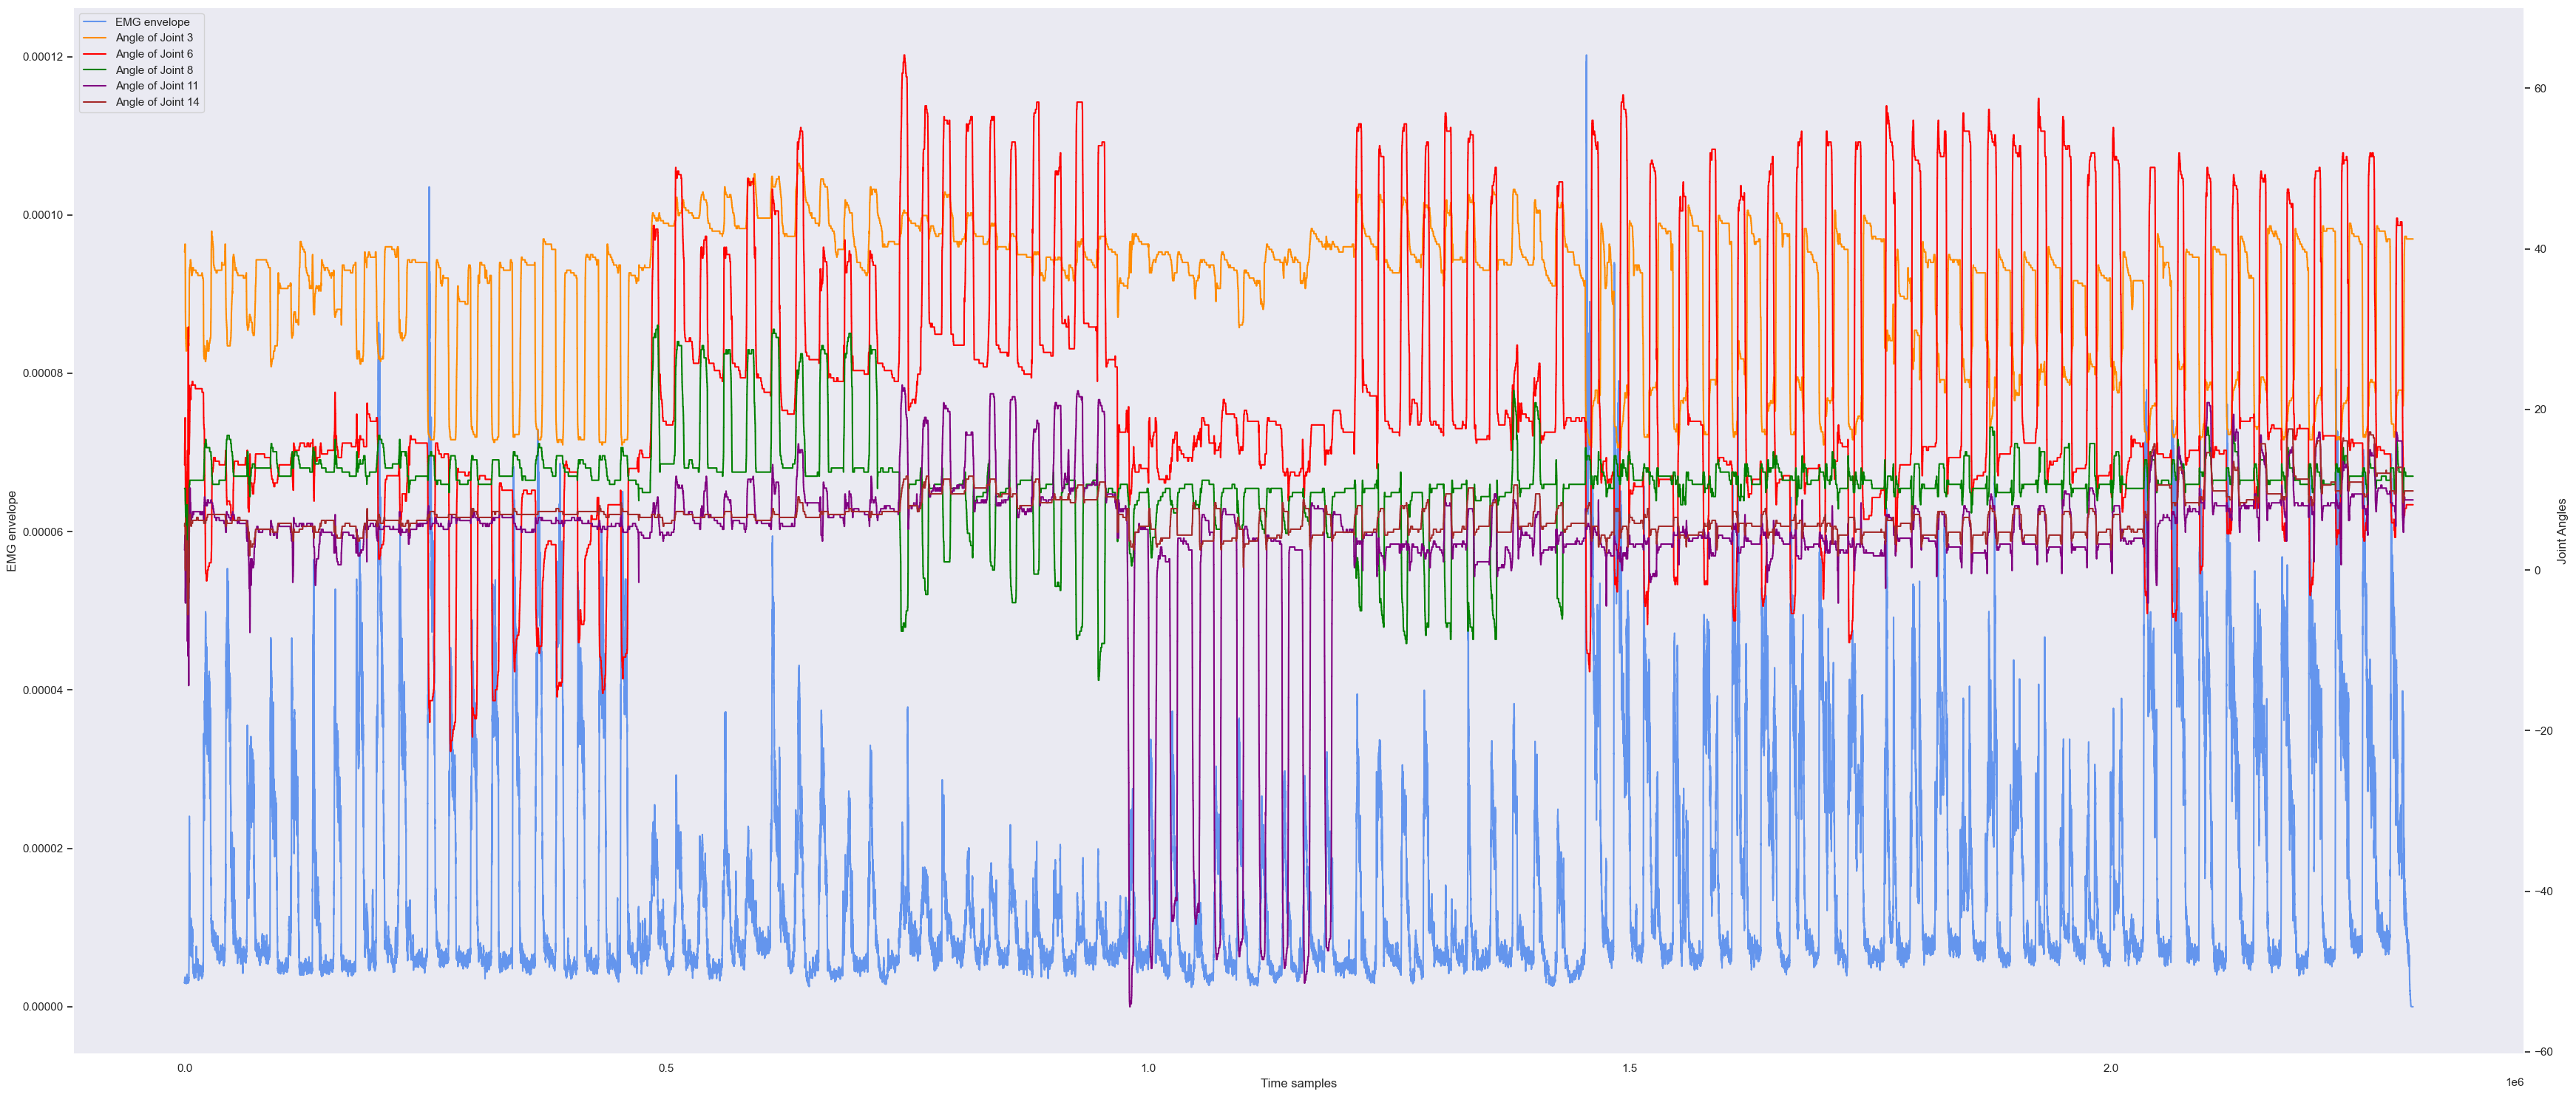

In [26]:
# For Test dataset
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes_test = convolve1d(emg_rectified_test, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots(figsize=(35, 15))

# Plot the EMG envelope
ax.plot(EMG_envelopes_test[:, 0], color='cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

# Create a twin axis for joint angles
joint_angle_ax = ax.twinx()

# Plot the joint angles
joint_angle_ax.plot(joint_angles_test[:, 0], color="darkorange", label="Angle of Joint 3")
joint_angle_ax.plot(joint_angles_test[:, 1], color="red", label="Angle of Joint 6")
joint_angle_ax.plot(joint_angles_test[:, 2], color="green", label="Angle of Joint 8")
joint_angle_ax.plot(joint_angles_test[:, 3], color="purple", label="Angle of Joint 11")
joint_angle_ax.plot(joint_angles_test[:, 4], color="brown", label="Angle of Joint 14")

# Set label for joint angles axis
joint_angle_ax.set_ylabel("Joint Angles")
joint_angle_ax.grid(False)

# Get handles and labels from both axes
emg_handles, emg_labels = ax.get_legend_handles_labels()
joint_handles, joint_labels = joint_angle_ax.get_legend_handles_labels()

# Combine handles and labels for a single legend
combined_handles = emg_handles + joint_handles
combined_labels = emg_labels + joint_labels

# Add a combined legend
ax.legend(combined_handles, combined_labels, loc='upper left')

plt.tight_layout()
plt.show()

Removing old variables because of memory issues

In [27]:
del emg_data
del emg_data_test
del emg_filtered
del emg_filtered_test
del emg_rectified
del emg_rectified_test
del emg_average_activations
del stimulus
del stimulus_test
del repetition
del repetition_test
del glove
del glove_test


### Performing Sliding Window 

Finger movements have relatively fast dynamics in EEG so we choose a window size of 100 ms, with an overlapping of 50% for a good balance between smoothness and computationa efficency, which gives a step size of 50 ms.

In [28]:
emg_window_length_sec = 100e-3  # [s]
incremental_window_length_sec = 50e-3  # [s]

In [29]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [30]:
# extract over lapping time windows on the train and test datasets
EMG_windows_train, Labels_windows_train = extract_time_windows_regression(EMG_envelopes, joint_angles, fs, emg_window_length_sec, incremental_window_length_sec)
EMG_windows_test, Labels_windows_test = extract_time_windows_regression(EMG_envelopes_test, joint_angles_test, fs, emg_window_length_sec, incremental_window_length_sec)

print(f"EMG train data shape: {EMG_windows_train.shape}, Train label shape: {Labels_windows_train.shape}")
print(f"EMG test data shape: {EMG_windows_test.shape}, Test label shape: {Labels_windows_test.shape}")

EMG train data shape: (22924, 200, 16), Train label shape: (22924, 200, 5)
EMG test data shape: (23133, 200, 16), Test label shape: (23133, 200, 5)


EMG test data:  
57309 windows of 200 samples (Window size in samples=Window length (seconds)×Sampling frequency (Hz)) with 16 channels for emg and 5 joint angles for the labels.

# Part 3.3: Feature Extraction (if we need extra features, frequency domain features are possible)

The following function will perform the extraction of the mean, standard deviation, maximum amplitude, waveform length, root mean square value, variance and slope sign change of the EMG data. It will also perform the extraction of the mean for the glove data.

In [31]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean and standard deviation of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    # Time-domain features (computed across the time axis: axis=1)
    EMG_mean = np.mean(EMG_windows, axis=1)  # Mean across the time axis
    EMG_std = np.std(EMG_windows, axis=1)    # Standard deviation across the time axis
    EMG_max_amplitude = np.max(EMG_windows, axis=1)  # Maximum amplitude
    EMG_waveform_length = np.sum(np.abs(np.diff(EMG_windows, axis=1)), axis=1)  # Waveform length
    EMG_rms = np.sqrt(np.mean(EMG_windows**2, axis=1))  # RMS
    EMG_variance = np.var(EMG_windows, axis=1)  # Variance

    # Slope Sign Changes (SSC): Count slope changes along time axis
    EMG_ssc = np.sum((np.diff(EMG_windows, axis=1)[:, :-1, :] * np.diff(EMG_windows, axis=1)[:, 1:, :]) < 0, axis=1)

    # Label features (mean of the windowed labels, axis=1)
    Labels_mean = np.mean(Labels_windows, axis=1)

    # Concatenate features of each window
    EMG_extracted_features = np.concatenate(
        (EMG_mean, EMG_std, EMG_max_amplitude, EMG_waveform_length, EMG_rms, EMG_variance, EMG_ssc),axis=1)
    return EMG_extracted_features, Labels_mean

Now we need to normalize the extracted features. We want to do this in order to compute their correlation. Therefore, we should standardize them so that all the values can be compared to the other ones. We want to standardize them across time, and not across electrodes (in the case of EMG signals) or sensors (in the case of glove information).

In [32]:
def standardize_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    EMG_channels = EMG_windows.shape[2]
    Labels_channels = Labels_windows.shape[2]
    EMG_extracted_features, Labels_extracted_features = extract_features(EMG_windows, Labels_windows)
    EMG_feature_number = EMG_extracted_features.shape[1]/EMG_channels
    Label_feature_number = Labels_extracted_features.shape[1]/Labels_channels

    # We create empty data structures that this function will return
    EMG_standardized_features = np.zeros(EMG_extracted_features.shape)
    Label_standardized_features = np.zeros(Labels_extracted_features.shape)

    # We must standardize for all features, for all channels
    for EMG_feature_index in range(int(EMG_channels * EMG_feature_number)):
        EMG_standardized_features[:, EMG_feature_index] = (EMG_extracted_features[:, EMG_feature_index] - np.mean(EMG_extracted_features[:, EMG_feature_index])) / np.std(EMG_extracted_features[:, EMG_feature_index])
    for Label_feature_index in range(int(Labels_channels * Label_feature_number)):
        Label_standardized_features[:, Label_feature_index] = (Labels_extracted_features[:, Label_feature_index] - np.mean(Labels_extracted_features[:, Label_feature_index])) / np.std(Labels_extracted_features[:, Label_feature_index])

    return EMG_standardized_features, Label_standardized_features

In [33]:
EMG_train_extracted_features, Labels_train_features = extract_features(EMG_windows_train, Labels_windows_train)
EMG_test_extracted_features, Labels_test_features = extract_features(EMG_windows_test, Labels_windows_test)

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_features.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_features.shape))

EMG_train_extracted_normalized_features, Labels_train_normalized_features = standardize_features(EMG_windows_train, Labels_windows_train)
EMG_test_extracted_normalized_features, Labels_testnormalized_features = standardize_features(EMG_windows_test, Labels_windows_test)
print("EMG train extracted normalized features shape: {}, Finger labels normalized feature shape:{}".format(EMG_train_extracted_normalized_features.shape, Labels_train_normalized_features.shape))
print("EMG test extracted normalized features shape: {}, Finger labels normalized feature shape:{}".format(EMG_test_extracted_normalized_features.shape, Labels_testnormalized_features.shape))

EMG train extracted features shape: (22924, 112), Finger labels feature shape:(22924, 5)
EMG test extracted features shape: (23133, 112), Finger labels feature shape:(23133, 5)
EMG train extracted normalized features shape: (22924, 112), Finger labels normalized feature shape:(22924, 5)
EMG test extracted normalized features shape: (23133, 112), Finger labels normalized feature shape:(23133, 5)


Now we can check the correlation between the EMG data and glove data features. We can also visualize them.

In [34]:
def featres_correlation_matrix(EMG_normalized_features, Label_normalized_features):
    EMG_features = EMG_normalized_features.shape[1]
    Label_features = Label_normalized_features.shape[1]

    # We construcct the returned data srtucture
    correlation = np.zeros([EMG_features, Label_features])
    for EMG_feature_index in range(EMG_features):
        for Label_feature_index in range(Label_features):
            # We take the value at the index [0, 1] because otherwise we would get the correlation between the same value twice
            correlation[EMG_feature_index, Label_feature_index] = (np.corrcoef(EMG_normalized_features[:, EMG_feature_index], Label_normalized_features[:, Label_feature_index], rowvar=False))[0, 1]
    return correlation

In [35]:
def visualize_correlation(correlation, EMG_channels, Label_channels, EMG_features, Label_features):
    number_EMG_features = len(EMG_features)
    number_Label_features = len(Label_features)
    #fig, ax = plt.subplots(len(EMG_features), len(Label_features), figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
    #ax = ax.ravel()
    for EMG_id, EMG_feature in enumerate(EMG_features):
        for Label_id, Label_feature in enumerate(Label_features):
            feature_correlation = correlation[EMG_id::number_EMG_features, Label_id::number_Label_features]
            fig, ax = plt.subplots()
            sns.heatmap(feature_correlation)#, ax=ax[EMG_id] ,xticklabels=False, yticklabels=False, cbar = True)
            ax.title.set_text("Correlation between " + EMG_feature + " and " +  Label_feature)
            ax.set_xlabel("Label channels")
            ax.set_ylabel("EMG channels")
            plt.show()
    

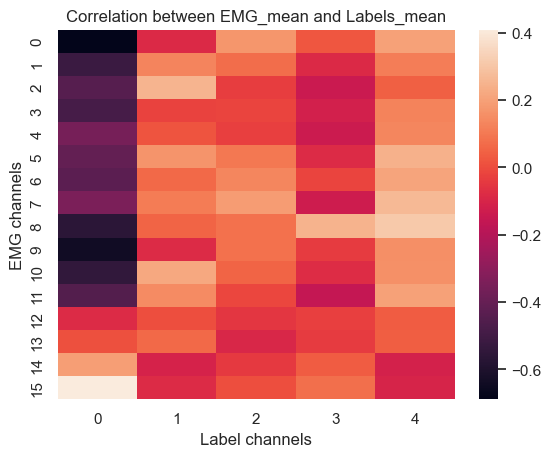

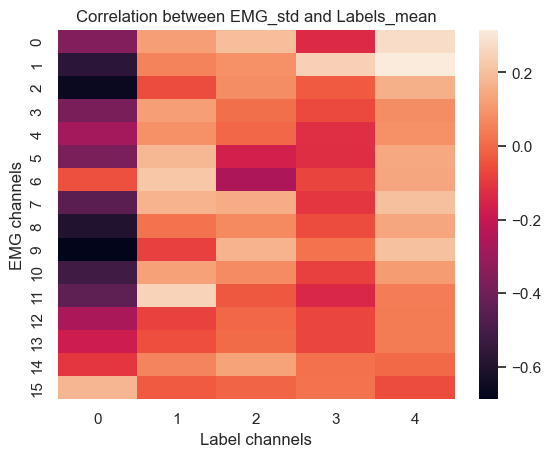

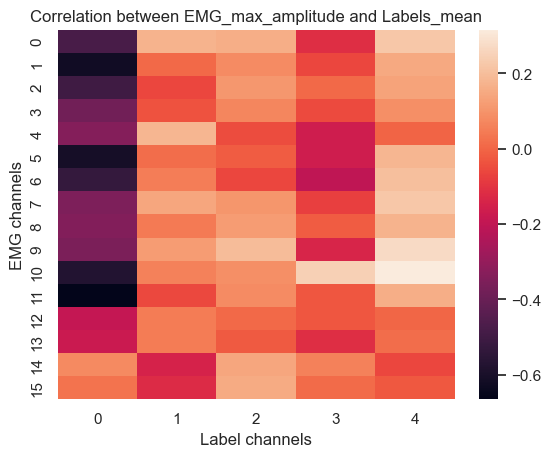

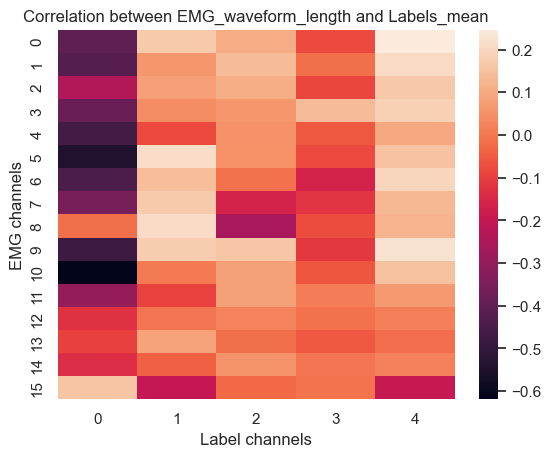

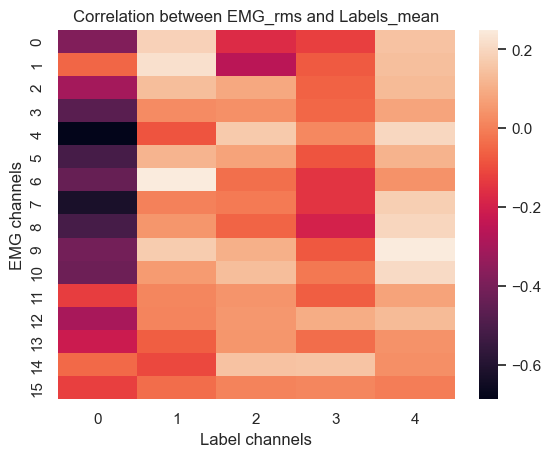

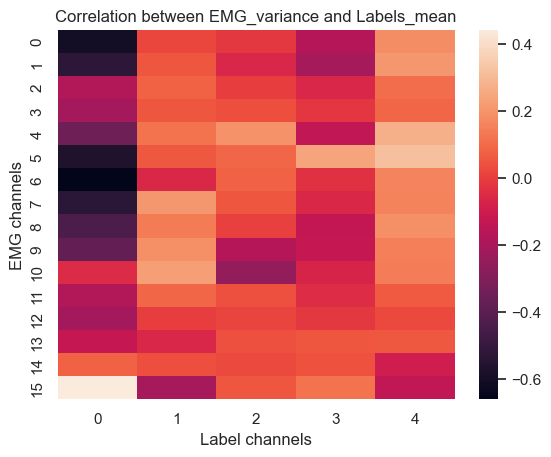

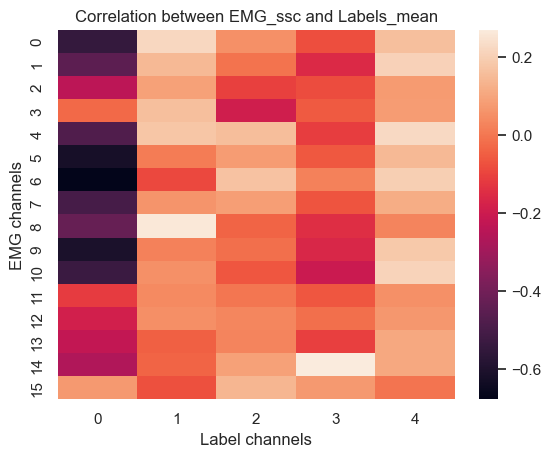

In [36]:
train_correlation = featres_correlation_matrix(EMG_train_extracted_normalized_features, Labels_train_normalized_features)
visualize_correlation(train_correlation, EMG_windows_train.shape[2], Labels_windows_train.shape[2], ["EMG_mean", "EMG_std", "EMG_max_amplitude", "EMG_waveform_length", "EMG_rms", "EMG_variance", "EMG_ssc"], ["Labels_mean"])

# Interpretation

# Part 3.4: Regression on the kinematics

We need to implement a Support Vector Regression, also known as SVR. There are 5 joints of interest in the glove data. Therefore, we will need to fot the SVR 5 times (one for each joint).

In [ ]:
from sklearn.svm import SVR 
from sklearn.kernel_approximation import Nystroem

# We create a SVR regressor. We do not want a linear one since the data is not linear
svr_regressor = SVR(kernel='rbf')

# We train a SVR regressor over the train data for each joint. We reshape the data to suit the needs of the classifier.
#reshaped_EMG_train = EMG_windows_train.reshape((EMG_windows_train.shape[0] * EMG_windows_train.shape[1], EMG_windows_train.shape[2]))
#reshaped_Label_train = Labels_windows_train.reshape((Labels_windows_train.shape[0] * Labels_windows_train.shape[1], Labels_windows_train.shape[2]))
#reshaped_EMG_test = EMG_windows_test.reshape((EMG_windows_test.shape[0] * EMG_windows_test.shape[1], EMG_windows_test.shape[2]))
#reshaped_Label_test = Labels_windows_test.reshape((Labels_windows_test.shape[0] * Labels_windows_test.shape[1], Labels_windows_test.shape[2]))

# We construct an empty prediction array
Labels_pred = np.zeros(joint_angles_test.shape)

# Since the amount of data is way too great, we do not use all of the samples
feature_map_nystroem = Nystroem(n_jobs = -4)
partial_train_data = feature_map_nystroem.fit_transform(EMG_envelopes)
partial_test_data = feature_map_nystroem.fit_transform(EMG_envelopes_test)
for Label_id in range(joint_angles.shape[1]):
    print("Start of fit")
    svr_regressor = svr_regressor.fit(partial_data, joint_angles[:, Label_id])
    print("Start of prediction")
    Labels_pred[:, Label_id] = svr_regressor.predict(EMG_envelopes_test)

Start of fit


Now, we can visualize the prediction, compared to the actual test values.

In [ ]:
for Label_id, Label_channel in enumerate([3,6,8,11,14]):
    fig, ax = plt.subplots()
    plt.plot(Labels_pred[:, Label_id], color='red', label='prediction')
    plt.plot(joint_angles_test[:, Label_id], color='green', label='data')
    plt.title("Prediction and data for channel " + str(Label_channel))
    plt.show()


# Part 3.5: Evaluating the performances